In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf
from skrf import Frequency, Network

# Parameters

In [3]:
Nf = 901
L = 0.5  # Length of the cable (meters)
c = 2e8  # Group velocity (m/s)

Frequency range

In [4]:
f = np.linspace(0.1e9, 10e9, Nf)  # Frequency array
coupler=rf.Network("../Sonnet_files/Directional coupler/Coupler.s4p")
freq =coupler.frequency

# Excitation line 

Scattering matrix for propagation in a 1-meter stainless steel cable ($\alpha = -1 \, \mathrm{dB/m/\sqrt{GHz}}$)

In [5]:
alpha_stainless = 10**-0.1
s_prop = np.zeros((Nf, 2, 2), dtype=complex)
attenuation = np.exp(-alpha_stainless * L * np.sqrt(f * 1e-9))
phase_shift = np.exp(-1j * 2 * np.pi * f / c * L)
s_prop[:, 0, 1] = attenuation * phase_shift
s_prop[:, 1, 0] = attenuation * phase_shift
cable_SS = Network(frequency=freq, s=s_prop, z0=50, name='cable_SS')

Scattering matrix for the connector1 ($r_1=0.01$, $t_1=\sqrt{1-r_1^2}$) the connector2 ($r_2=0.05$, $t_2=\sqrt{1-r_2^2}$)

In [6]:
r1 = 0.01
t1 = np.sqrt(1 - r1**2)
s_con1 = np.zeros((Nf, 2, 2), dtype=complex)
s_con1[:, 0, 0] = r1
s_con1[:, 0, 1] = -t1
s_con1[:, 1, 0] = t1
s_con1[:, 1, 1] = r1
con1 = Network(frequency=freq, s=s_con1, z0=50, name='connector1')

r2 = 0.05
t2 = np.sqrt(1 - r1**2)
s_con2 = np.zeros((Nf, 2, 2), dtype=complex)
s_con2[:, 0, 0] = r2
s_con2[:, 0, 1] = -t2
s_con2[:, 1, 0] = t2
s_con2[:, 1, 1] = r2
con2 = Network(frequency=freq, s=s_con2, z0=50, name='connector2')

Scattering matrix for the 20 dB attenuator

In [7]:
s_att = np.zeros((Nf, 2, 2), dtype=complex)
s_att[:, 0, 0] = 0
s_att[:, 0, 1] = 0.1
s_att[:, 1, 0] = 0.1
s_att[:, 1, 1] = 0
att = Network(frequency=freq, s=s_att, z0=50, name='attenuator -20dB')


Cascade the networks: stainless cable $\rightarrow$ attenuator  $\rightarrow$ connector1  $\rightarrow$ stainless cable $\rightarrow$  attenuator using the cascade method, which handles transfer matrix calculations

In [8]:
excitation_line = cable_SS ** att ** con1** cable_SS** con2 ** att 

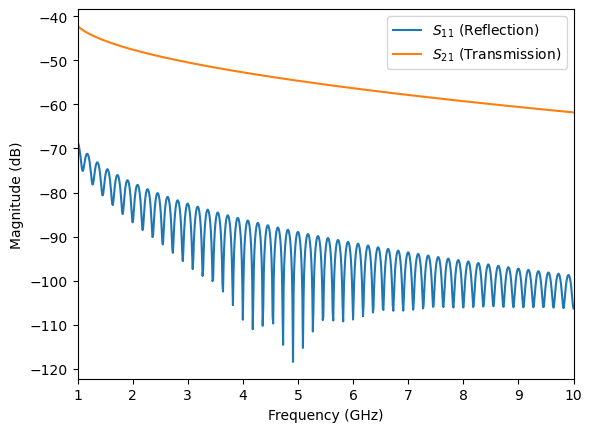

In [10]:
excitation_line.plot_s_db(m=0, n=0, label='$S_{11}$ (Reflection)')
excitation_line.plot_s_db(m=1, n=0, label='$S_{21}$ (Transmission)')

# Excitation line with low attenuation

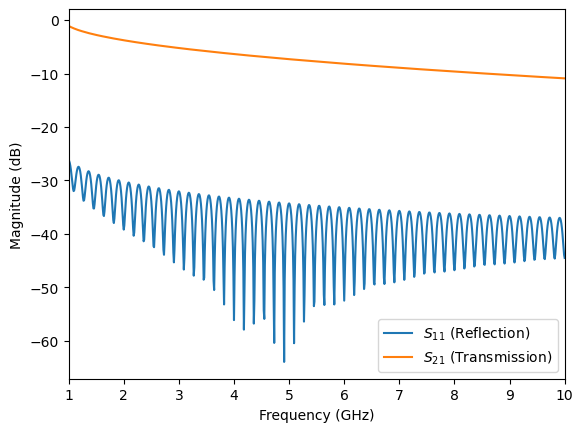

In [11]:
excitation_line_lowloss = con1** cable_SS** con2
excitation_line_lowloss.plot_s_db(m=0, n=0, label='$S_{11}$ (Reflection)')
excitation_line_lowloss.plot_s_db(m=1, n=0, label='$S_{21}$ (Transmission)')

DUT (resistor and capacitor)

In [16]:
port1 = rf.Circuit.Port(frequency=freq, name='port1', z0=50)
port2 = rf.Circuit.Port(frequency=freq, name='port2', z0=50)
ground4 = rf.Circuit.Ground(freq, name='GND4')
ground5 = rf.Circuit.Ground(freq, name='GND5')
ground6 = rf.Circuit.Ground(freq, name='GND6')
R25 = rf.Circuit.SeriesImpedance(freq, name='R25', z0=50,Z=25)
R75 = rf.Circuit.SeriesImpedance(freq, name='R75', z0=50,Z=75)
R100 = rf.Circuit.SeriesImpedance(freq, name='R100', z0=50,Z=100)
C1 = rf.Circuit.SeriesImpedance(freq, name='C1', z0=50,Z=1/(1j*freq.w*40e-12))
C2 = rf.Circuit.SeriesImpedance(freq, name='C2', z0=50,Z=1/(1j*freq.w*20e-12))
C3 = rf.Circuit.SeriesImpedance(freq, name='C3', z0=50,Z=1/(1j*freq.w*10e-12))
label_DUT_Re=[r"$R=25\, \Omega$",r"$R=75\, \Omega$",r"$R=100\, \Omega$"]
label_DUT_Im=[r"$C=40\, pF$",r"$C=20\, pF$",r"$C=10\, pF$"]
label_DUT=[r"$25\, \Omega \parallel 40pF$",r"$75\, \Omega \parallel 20pF$",r"$100\, \Omega \parallel 10pF$"]

In [17]:
connexion_DUT0 = [ [(port1, 0), (excitation_line_lowloss, 0)],
              [(excitation_line_lowloss, 1), (R25, 0),(C1,0)],
              [(R25, 1),(C1,1),(ground4,0)]]
connexion_DUT1 = [ [(port1, 0), (excitation_line_lowloss, 0)],
              [(excitation_line_lowloss, 1), (R75, 0),(C2,0)],
              [(R75, 1),(C2,1),(ground5,0)]]
connexion_DUT2 = [ [(port1, 0), (excitation_line_lowloss, 0)],
              [(excitation_line_lowloss, 1), (R100, 0),(C3,0)],
              [(R100, 1),(C3,1),(ground6,0)]]

In [18]:
resulting_DUT=[]
resulting_DUT.append(rf.Circuit(connexion_DUT0))
resulting_DUT.append(rf.Circuit(connexion_DUT1))
resulting_DUT.append(rf.Circuit(connexion_DUT2))


Text(0, 0.5, 'Im $\\Gamma$')

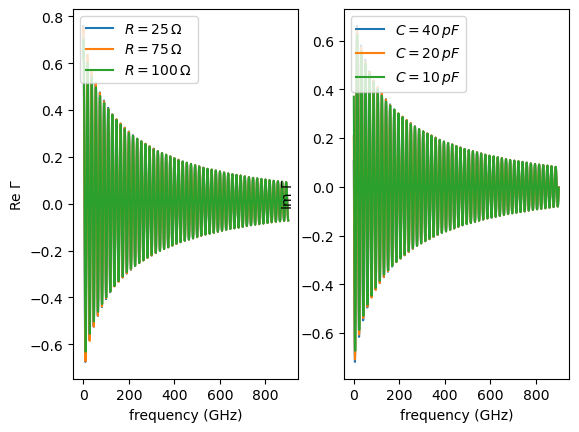

In [21]:
Gamma_DUT=[]
Gamma_DUT.append(resulting_DUT[0].s[:,0,0])
Gamma_DUT.append(resulting_DUT[1].s[:,0,0])
Gamma_DUT.append(resulting_DUT[2].s[:,0,0])
for k in range(3):
    plt.subplot(1, 2, 1)
    plt.plot(np.real(Gamma_DUT[k]), label=label_DUT_Re[k])
    plt.legend(loc="upper left")
    plt.xlabel("frequency (GHz)")
    plt.ylabel(r"Re $\Gamma$")  
    plt.subplot(1, 2, 2)
    plt.plot(np.imag(Gamma_DUT[k]), label=label_DUT_Im[k])
plt.legend(loc="upper left")
plt.xlabel("frequency (GHz)")
plt.ylabel(r"Im $\Gamma$") 

Text(0, 0.5, 'Im Y')

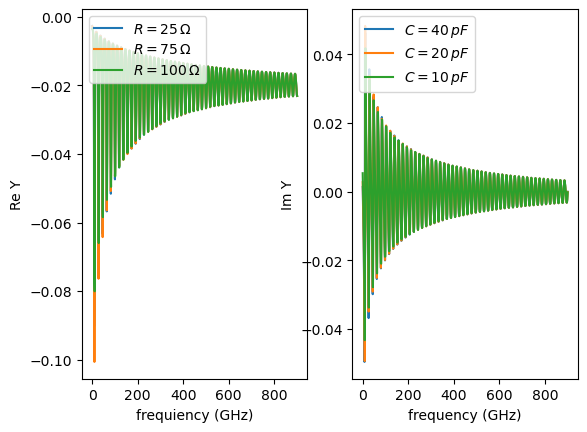

In [29]:
Z_ref=[]
for k in range(3):
    Z_ref.append(50*(Gamma_DUT[k]+1)/(Gamma_DUT[k]-1))
    
for k in range(3):
    plt.subplot(1, 2, 1)
    plt.plot(np.real(1/Z_ref[k]), label=label_DUT_Re[k])
    plt.legend(loc="upper left")
    plt.xlabel("frequiency (GHz)")
    plt.ylabel("Re Y")  
    #plt.ylim(-1,1)
    plt.subplot(1, 2, 2)
    plt.plot(np.imag(1/Z_ref[k]), label=label_DUT_Im[k])
plt.legend(loc="upper left")
plt.xlabel("frequency (GHz)")
plt.ylabel("Im Y") 

# Detection  line 

Scattering matrix for propagation in a 0.5-meter NbTi cable ($\alpha = 0 \, \mathrm{dB/m/\sqrt{GHz}}$) +  0.5 -meter stainless steel cable ($\alpha = -1 \, \mathrm{dB/m/\sqrt{GHz}}$)

In [30]:
alpha_stainless = 10**-0.1
s_prop = np.zeros((Nf, 2, 2), dtype=complex)
attenuation = np.exp(-alpha_stainless * L * np.sqrt(f * 1e-9))
phase_shift = np.exp(-1j * 2 * np.pi * f / c * L)
s_prop[:, 0, 1] =  phase_shift
s_prop[:, 1, 0] =  phase_shift
cable_NbTi = Network(frequency=freq, s=s_prop, z0=50, name='Cable NbTi')

Scattering matrix for the g=40dB amplifier

In [31]:
g=40
s_amp = np.zeros((Nf, 2, 2), dtype=complex)
s_amp[:, 0, 0] = 0.1
s_amp[:, 0, 1] = 0
s_amp[:, 1, 0] = 10**(g/20)
s_amp[:, 1, 1] = 0
amp = Network(frequency=freq, s=s_amp, z0=50, name='LNA')

Cascade the networks: NbTi cable $\rightarrow$ connector1 $\rightarrow$ amplifier  $\rightarrow$ connector2 $\rightarrow$ stainless cable using the cascade method, which handles transfer matrix calculations

In [32]:
detection_line = cable_NbTi **con1** amp ** con2 ** cable_SS

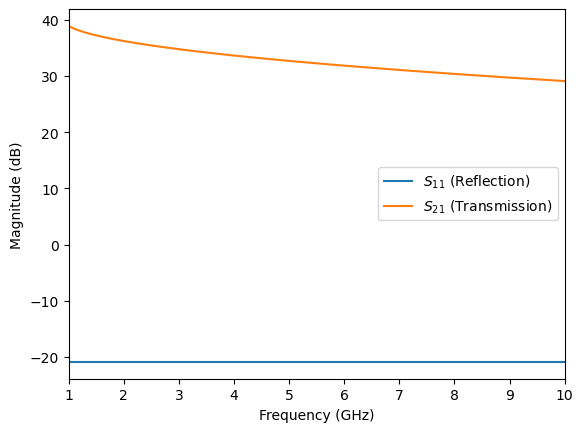

In [33]:
detection_line.plot_s_db(m=0, n=0, label='$S_{11}$ (Reflection)')
detection_line.plot_s_db(m=1, n=0, label='$S_{21}$ (Transmission)')

# Network element of the calibration circuit

Coupler

In [34]:
coupler=rf.Network("../Sonnet_files/Directional coupler/Coupler.s4p")

Calibration standard

In [35]:
line = rf.media.DefinedGammaZ0(frequency=freq, z0=50)
res_open =line.resistor(1e9, name='open') # rf.Circuit.Open(freq, name='open')
res_short = line.resistor(1e-9, name='short') # be carfull, do not take 0
res_match_cal = line.resistor(50, name='match_cal') # load resistance
res_match = line.resistor(50, name='match')

DUT (resistor and capacitor)

In [36]:
R25 = rf.Circuit.SeriesImpedance(freq, name='R25', z0=50,Z=25)
R75 = rf.Circuit.SeriesImpedance(freq, name='R75', z0=50,Z=75)
R100 = rf.Circuit.SeriesImpedance(freq, name='R100', z0=50,Z=100)
C1 = rf.Circuit.SeriesImpedance(freq, name='C1', z0=50,Z=1/(1j*freq.w*40e-12))
C2 = rf.Circuit.SeriesImpedance(freq, name='C2', z0=50,Z=1/(1j*freq.w*20e-12))
C3 = rf.Circuit.SeriesImpedance(freq, name='C3', z0=50,Z=1/(1j*freq.w*10e-12))

Ports and grond

In [37]:
port1 = rf.Circuit.Port(frequency=freq, name='port1', z0=50)
port2 = rf.Circuit.Port(frequency=freq, name='port2', z0=50)
ground0 = rf.Circuit.Ground(freq, name='GND0')
ground1 = rf.Circuit.Ground(freq, name='GND1')
ground2 = rf.Circuit.Ground(freq, name='GND2')
ground3 = rf.Circuit.Ground(freq, name='GND3')
ground4 = rf.Circuit.Ground(freq, name='GND4')
ground5 = rf.Circuit.Ground(freq, name='GND5')
ground6 = rf.Circuit.Ground(freq, name='GND6')

In [39]:
Cal=[]
Cal.append(res_open)
Cal.append(res_short)
Cal.append(res_match_cal)
label_cal=['Open','Short','Load']
label_DUT_Re=[r"$R=25\, \Omega$",r"$R=75\, \Omega$",r"$R=100\, \Omega$"]
label_DUT_Im=[r"$C=40\, pF$",r"$C=20\, pF$",r"$C=10\, pF$"]
label_DUT=[r"$25\, \Omega \parallel 40pF$",r"$75\, \Omega \parallel 20pF$",r"$100\, \Omega \parallel 10pF$"]

Connexion in the network

In [40]:
connexion_open =[ [(port1, 0), (excitation_line, 0)],
              [(excitation_line, 1), (coupler, 3)],
              [(coupler, 1), (detection_line, 0)],
              [(detection_line, 1),(port2, 0)],
              [(coupler, 2), (res_match, 0)],
              [(res_match, 1),(ground0,0)],
              [(coupler, 0), (Cal[0], 0)],
              [(Cal[0], 1),(ground1,0)]]


connexion_short = [ [(port1, 0), (excitation_line, 0)],
              [(excitation_line, 1), (coupler, 3)],
              [(coupler, 1), (detection_line, 0)],
              [(detection_line, 1),(port2, 0)],
              [(coupler, 2), (res_match, 0)],
              [(res_match, 1),(ground0,0)],
              [(coupler, 0), (Cal[1], 0)],
              [(Cal[1], 1),(ground2,0)]]

connexion_load = [ [(port1, 0), (excitation_line, 0)],
              [(excitation_line, 1), (coupler, 3)],
              [(coupler, 1), (detection_line, 0)],
              [(detection_line, 1),(port2, 0)],
              [(coupler, 2), (res_match, 0)],
              [(res_match, 1),(ground0,0)],
              [(coupler, 0), (Cal[2], 0)],
              [(Cal[2], 1),(ground3,0)]]


connexion_DUT0 = [ [(port1, 0), (excitation_line, 0)],
              [(excitation_line, 1), (coupler, 3)],
              [(coupler, 1), (detection_line, 0)],
              [(detection_line, 1),(port2, 0)],
              [(coupler, 2), (res_match, 0)],
              [(res_match, 1),(ground0,0)],
              [(coupler, 0), (R25, 0),(C1,0)],
              [(R25, 1),(C1,1),(ground4,0)]]

connexion_DUT1 = [ [(port1, 0), (excitation_line, 0)],
              [(excitation_line, 1), (coupler, 3)],
              [(coupler, 1), (detection_line, 0)],
              [(detection_line, 1),(port2, 0)],
              [(coupler, 2), (res_match, 0)],
              [(res_match, 1),(ground0,0)],
              [(coupler, 0), (R75, 0),(C2,0)],
              [(R75, 1),(C2,1),(ground5,0)]]

connexion_DUT2 = [ [(port1, 0), (excitation_line, 0)],
              [(excitation_line, 1), (coupler, 3)],
              [(coupler, 1), (detection_line, 0)],
              [(detection_line, 1),(port2, 0)],
              [(coupler, 2), (res_match, 0)],
              [(res_match, 1),(ground0,0)],
              [(coupler, 0), (R100, 0),(C3,0)],
              [(R100, 1),(C3,1),(ground6,0)]]


resulting_open = rf.Circuit(connexion_open)
resulting_short = rf.Circuit(connexion_short)
resulting_load = rf.Circuit(connexion_load)
resulting_DUT0 = rf.Circuit(connexion_DUT0)
resulting_DUT1 = rf.Circuit(connexion_DUT1)
resulting_DUT2 = rf.Circuit(connexion_DUT2)

Find the nodes corresponding to the ports

In [41]:
resulting_short.port_indexes

[0, 7]

In [42]:
help(resulting_DUT0.plot_graph)

Help on method plot_graph in module skrf.circuit:

plot_graph(**kwargs) method of skrf.circuit.Circuit instance
    Plot the graph of the circuit using networkx drawing capabilities.

    Customisation options with default values:
    ::
        'network_shape': 's'
        'network_color': 'gray'
        'network_size', 300
        'network_fontsize': 7
        'inter_shape': 'o'
        'inter_color': 'lightblue'
        'inter_size', 300
        'port_shape': '>'
        'port_color': 'red'
        'port_size', 300
        'port_fontsize': 7
        'edges_fontsize': 5
        'network_labels': False
        'edge_labels': False
        'inter_labels': False
        'port_labels': False
        'label_shift_x': 0
        'label_shift_y': 0



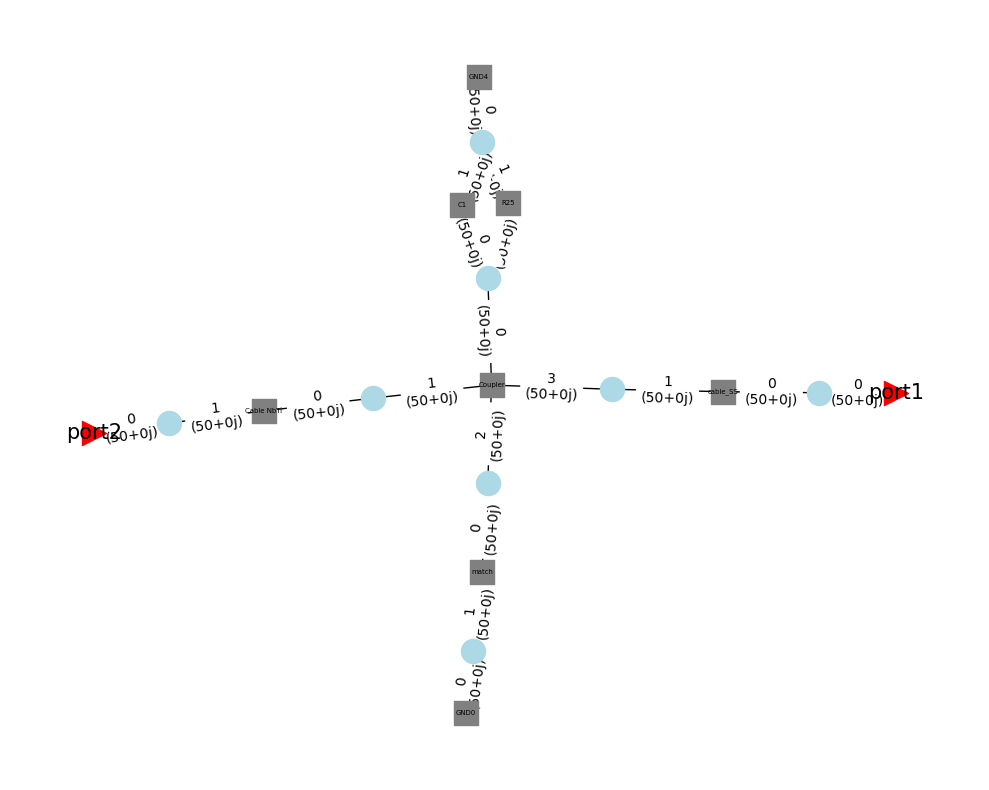

In [44]:
resulting_DUT0.plot_graph(network_shape='s',network_labels=True, network_fontsize=5,
               port_labels=True, port_fontsize=15,
              edge_labels=True, edge_fontsize=10)

In [45]:
S_cal=[]
S_cal.append(resulting_open.s[:,7,0])
S_cal.append(resulting_short.s[:,7,0])
S_cal.append(resulting_load.s[:,7,0])

S_DUT=[]
S_DUT.append(resulting_DUT0.s[:,7,0])
S_DUT.append(resulting_DUT1.s[:,7,0])
S_DUT.append(resulting_DUT2.s[:,7,0])

Text(0, 0.5, '$|S_{21}|$')

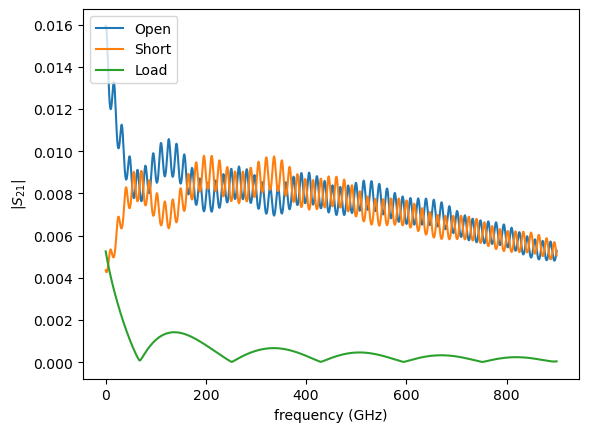

In [46]:
plt.plot(np.abs(resulting_open.s[:,7,0]), label=label_cal[0])
plt.plot(np.abs(resulting_short.s[:,7,0]), label=label_cal[1])
plt.plot(np.abs(resulting_load.s[:,7,0]), label=label_cal[2])
plt.legend(loc="upper left")
plt.xlabel("frequency (GHz)")
plt.ylabel(r"$|S_{21}|$")

Text(0, 0.5, '$|S_{21}|$')

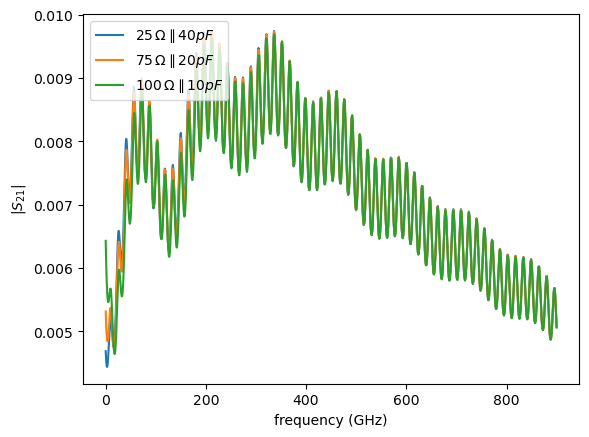

In [47]:
plt.plot(np.abs(resulting_DUT0.s[:,7,0]), label=label_DUT[0])
plt.plot(np.abs(resulting_DUT1.s[:,7,0]), label=label_DUT[1])
plt.plot(np.abs(resulting_DUT2.s[:,7,0]), label=label_DUT[2])
plt.legend(loc="upper left")
plt.xlabel("frequency (GHz)")
plt.ylabel(r"$|S_{21}|$")

Calculation of calibration coefficients $\alpha$, $\beta$ and $\gamma$

In [48]:
alpha=2*(S_cal[2]-S_cal[1])*(S_cal[0]-S_cal[2])/(S_cal[0]-S_cal[1])
beta=S_cal[2]
gamma=1+2*(S_cal[1]-S_cal[2])/(S_cal[0]-S_cal[1])

Text(0, 0.5, 'magnitude')

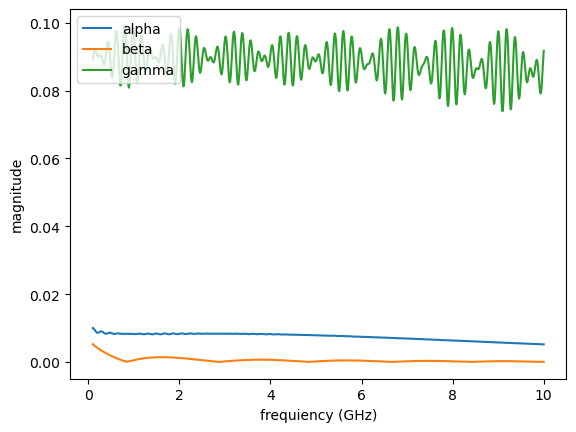

In [49]:
plt.plot(1e-9*f,np.abs(alpha), label="alpha")
plt.plot(1e-9*f,np.abs(beta), label="beta")
plt.plot(1e-9*f,np.abs(gamma), label="gamma")
plt.legend(loc="upper left")
plt.xlabel("frequiency (GHz)")
plt.ylabel("magnitude")

Text(0, 0.5, 'Im Y')

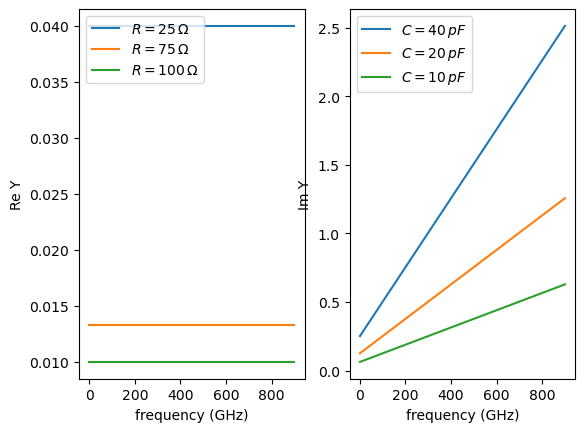

In [51]:
Gamma=[]
z=[]

for k in range(3):
    Gamma_meas=S_DUT[k]   
    Gamma.append((Gamma_meas-beta)/(alpha+gamma*(Gamma_meas-beta)))
    z.append(50*(Gamma[k]+1)/(1-Gamma[k]))
    
for k in range(3):
    plt.subplot(1, 2, 1)
    plt.plot(np.real(1/z[k]), label=label_DUT_Re[k])
    plt.legend(loc="upper left")
    plt.xlabel("frequency (GHz)")
    plt.ylabel("Re Y")  
    plt.subplot(1, 2, 2)
    plt.plot(np.imag(1/z[k]), label=label_DUT_Im[k])
plt.legend(loc="upper left")
plt.xlabel("frequency (GHz)")
plt.ylabel("Im Y") 